In [1]:
"""
This file is altered from its original so that more than 2000 genes are retained in the final gene-set
original file: Downsample_integrate.ipynb
"""
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

In [2]:
import bbknn
import matplotlib.pyplot as plt

In [3]:
#load data from adult large intestine
dataPath  = '../data/Adult_large_Intestine/gca_adult_largeInt.h5ad'
adata = sc.read_h5ad(dataPath)

In [4]:
# load names of QC'd downsampled cells from external QC and sampling
cellPath = '../data/gca_downsampled_cell_names.csv'
cellNames = pd.read_table(cellPath)
cellNames=cellNames.x

In [5]:
#subset data to only cells stored in cellnames
adata = adata[cellNames, :]

In [6]:
#sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color = 'Integrated_05')
#sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color  = 'Integrated_05')

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)

/home/johbas/.local/.conda/envs/gcAtlas/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
adata.raw = adata

In [ ]:
adata.X

In [9]:
adata=adata[:,adata.var.highly_variable]
#genes should not be removed for running cellphone db

In [10]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
#issue 526 regressing out mt and detected genes could do more harm than good

In [11]:
sc.pp.scale(adata, max_value=10)
#data should not be scaled for running cellphone db

In [10]:
adata.X = adata.X.toarray()
adata.X = np.asarray(adata.X)
#converting first to array then to np.array is much faster

In [12]:
sc.pp.pca(adata)

In [13]:
bbknn.bbknn(adata, batch_key='Donor')

In [14]:
sc.tl.leiden(adata)
bbknn.ridge_regression(adata, batch_key=['batch'], confounder_key=['leiden'])
sc.tl.pca(adata)
bbknn.bbknn(adata, batch_key='batch')
#bbknn.bbknn(adata, batch_key='Fraction')

In [15]:
sc.pp.neighbors(adata,n_neighbors = 10, n_pcs=40)
sc.tl.umap(adata)

In [16]:
plt.rcParams['figure.figsize' ] = [18, 12]

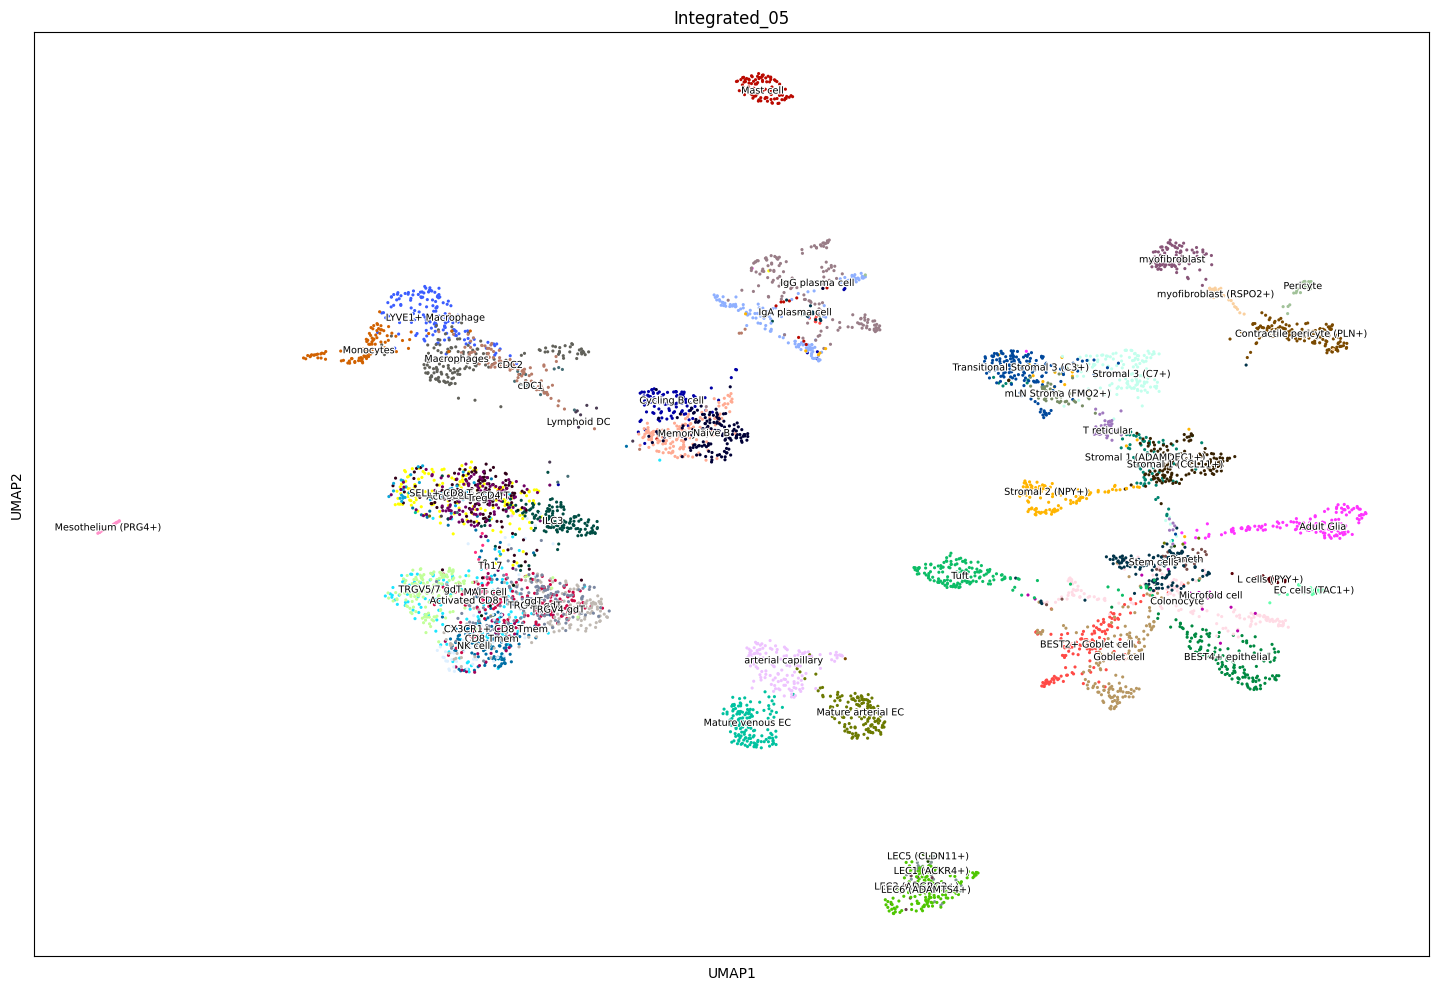

In [17]:
sc.pl.umap(adata, color = 'Integrated_05', legend_loc = 'on data', legend_fontsize='x-small', legend_fontweight='medium', legend_fontoutline=1.5)

In [18]:
adata.X

array([[-0.00017526,  0.        ,  0.        , ..., -0.00366872,
         0.        ,  0.        ],
       [-0.00029726,  0.        ,  0.        , ..., -0.00666488,
         0.        ,  0.        ],
       [-0.00013496,  0.        ,  0.        , ...,  0.01314598,
         0.        ,  0.        ],
       ...,
       [ 0.00016138,  0.        ,  0.        , ..., -0.00107581,
         0.        ,  0.        ],
       [ 0.00016138,  0.        ,  0.        , ..., -0.00107581,
         0.        ,  0.        ],
       [ 0.00016138,  0.        ,  0.        , ..., -0.00107581,
         0.        ,  0.        ]])

In [19]:
adata.write('../data/adult_largeInt_cellphonedb.h5ad')